In [19]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1
from tqdm import tqdm

import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task, filter_opto_data
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports
from Style.style_guide import transfection_style

os.chdir('/home/sambray/Documents/MS_analysis/')
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

## define trial by first poke times

In [16]:
track_type = "wtrack"
inbound_trial = []
trial_durations = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""



#################################
for transfected in [True,False]:
    dataset_key = {
                       # 'pulse_length_ms':40,
                       # "transfected":True,
                       "laser_power": 77,
                       'targeted_phase':90,
                        'animal':animal,
                        'transfected':transfected,
                        "track_type":track_type,
                        # "interval_list_name":"pos 3 valid times",
        }
        
    dataset = filter_opto_data(dataset_key)
    
    
    for nwb_file_name,interval_name in tqdm(zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name"))):
        key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name}
        if nwb_file_name=='Winnie20220722_.nwb' and (interval_name=='pos 1 valid times' or interval_name=='pos 3 valid times'):
            continue
        #outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName)&key).fetch('performance_outcomes')[0]
        poke_times = ((ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName)& key).fetch1("dio_first_poke_times")
        last_poke_times = ((ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key).fetch1("dio_last_poke_times")
        # trial_durations.extend(np.diff(poke_times))
        inbound_trial.extend([('inbound' in x) for x in outcomes[1:]])
        accuracy.extend([('incorrect' in x) for x in outcomes[1:]])
    
        #durations
        travel_intervals = np.array(filter_position_ports(key))
        for i in range(poke_times.size-1):
            travel_ = interval_list_intersect(np.array([[poke_times[i],poke_times[i+1]]]),travel_intervals)
            trial_durations.append(np.sum([interval[1]-interval[0] for interval in travel_]))
        # trial_durations.extend(poke_times[1:]-last_poke_times[:poke_times.size-1])
        
        #Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend([interval_list_contains(test_intervals,np.array([i])).size for i in poke_times[1:]])

        #transfected
        transfected_trial.extend(np.ones(outcomes.size-1)*int(transfected))

trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

datasets: 58


58it [00:12,  4.58it/s]


datasets: 42


42it [00:16,  2.51it/s]


In [15]:
key

{'nwb_file_name': 'Winnie20220722_.nwb',
 'interval_list_name': 'pos 3 valid times'}

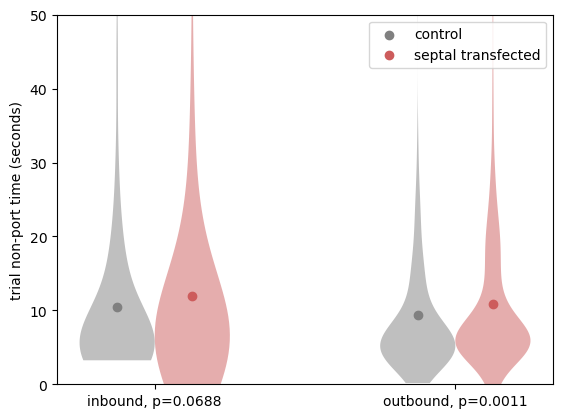

In [22]:
positions = np.array([0,2])
# control = plt.violinplot([trial_durations[inbound_trial & ~transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & ~transfected_trial& ~accuracy],],
#                positions = positions,
#                showmedians=False,showextrema=False,points=1000,)
# test = plt.violinplot([trial_durations[inbound_trial & transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & transfected_trial& ~accuracy],],
#                positions = positions+.5,
#                showmeans=False,showextrema=False,points=1000,)
# plt.scatter(positions,[np.mean(trial_durations[inbound_trial & ~transfected_trial & ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & ~transfected_trial& ~accuracy]),],color = 'cornflowerblue',label='control')
# plt.scatter(positions+.5,[np.mean(trial_durations[inbound_trial & transfected_trial& ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & transfected_trial& ~accuracy]),],color = 'firebrick',label='septal transfected')


control_sets = [trial_durations[inbound_trial & ~transfected_trial & opto_trial],
                trial_durations[~inbound_trial & ~transfected_trial& opto_trial],]
test_sets = [trial_durations[inbound_trial & transfected_trial& opto_trial],
                trial_durations[~inbound_trial & transfected_trial& opto_trial],]
control = plt.violinplot(control_sets,
               positions = positions,
               showmedians=False,showextrema=False,points=1000,)
test = plt.violinplot(test_sets,
               positions = positions+.5,
               showmeans=False,showextrema=False,points=1000,)

plt.scatter(positions,[np.mean(x) for x in control_sets],color = transfection_style['control'],label='control')
plt.scatter(positions+.5,[np.mean(x) for x in test_sets],color = transfection_style['transfected'],label='septal transfected')

from scipy.stats import ttest_ind
inbound_p = ttest_ind(trial_durations[inbound_trial & ~transfected_trial],trial_durations[inbound_trial & transfected_trial],equal_var=False)[1]
outbound_p = ttest_ind(trial_durations[~inbound_trial & ~transfected_trial],trial_durations[~inbound_trial & transfected_trial],equal_var=False)[1]

for pc in control['bodies']:
    pc.set_facecolor(transfection_style['control'])
    pc.set_alpha(.5)
for pc in test['bodies']:
    pc.set_facecolor(transfection_style['transfected'])
    pc.set_alpha(.5)
plt.xticks(positions+.25,labels=[f'inbound, p={np.round(inbound_p,4)}',f'outbound, p={np.round(outbound_p,4)}'])
plt.ylabel('trial non-port time (seconds)')
plt.ylim(0,50)

plt.legend()


### Separate inbound trials by accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


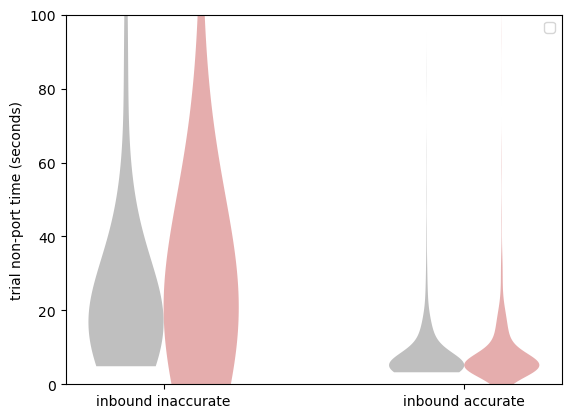

In [23]:
control = plt.violinplot([trial_durations[inbound_trial & ~transfected_trial& ~accuracy],
                trial_durations[inbound_trial & ~transfected_trial& accuracy],],
               positions = positions,
               showmedians=False,showextrema=False,points=1000,)
test = plt.violinplot([trial_durations[inbound_trial & transfected_trial& ~accuracy],
                trial_durations[inbound_trial & transfected_trial& accuracy],],
               positions = positions+.5,
               showmeans=False,showextrema=False,points=1000,)


for pc in control['bodies']:
    pc.set_facecolor(transfection_style['control'])
    pc.set_alpha(.5)
for pc in test['bodies']:
    pc.set_facecolor(transfection_style['transfected'])
    pc.set_alpha(.5)

plt.ylim(0,100)
plt.xticks(positions+.25,labels=['inbound inaccurate', 'inbound accurate'])
plt.ylabel('trial non-port time (seconds)')
plt.ylim(0,100)

plt.legend()

In [145]:
from scipy.stats import ttest_ind
inbound_p = ttest_ind(trial_durations[inbound_trial & ~transfected_trial],trial_durations[inbound_trial & transfected_trial],equal_var=False)[1]

outbound_p = ttest_ind(trial_durations[~inbound_trial & ~transfected_trial],trial_durations[~inbound_trial & transfected_trial],equal_var=False)[1]

0.23801773745361235

## Define Trial by running times

In [24]:
animal = "Winnie"
track_type = "wtrack"
dataset_key = {
                   # 'pulse_length_ms':40,
                   # "transfected":True,
                   "laser_power": 77,
                   'targeted_phase':90,
                    'animal':animal,
    }
    
dataset = (OptoStimProtocol *
           OptoStimProtocolTransfected *
           OptoStimProtocolLaser *
           OptoStimProtocolClosedLoop) & dataset_key

dataset = filter_animal(dataset,dataset_key['animal'])
dataset = filter_task(dataset,track_type)

inbound_trial = []
trial_durations = []
opto_trial = []
for nwb_file_name,interval_name in zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name")):
    key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name}
    
    break
interval = (IntervalList & key).fetch1("valid_times")
travel_intervals = np.array(filter_position_ports(key))

In [25]:
travel_durations = np.array([interval[1]-interval[0] for interval in travel_intervals])
ind = np.where(travel_durations>5)[0]
travel_durations = travel_durations[ind]
travel_intervals = travel_intervals[ind]

In [26]:
travel_durations

array([ 5.28599644, 27.58598161, 15.26398993, 43.7739706 , 68.00395441,
       19.40198708, 10.53399301, 29.49798036, 30.51197958,  6.88599539,
       29.72598004, 22.21598506,  8.68599415, 25.64998293, 40.86797261,
       15.99798918, 35.42797637,  5.74799609, 42.76197124, 21.51998568,
       31.31197906, 54.14796376, 25.56798291, 45.10396957, 31.19597912,
       34.20197725, 41.86597204, 41.87597179, 73.38995099, 21.1879859 ,
       16.30198908, 27.82198119,  5.56599617])